<a href="https://colab.research.google.com/github/lucasocp/lucasocp/blob/main/KaggleManual_Auto_KNN_KMeans_Colab_EDA_Copia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto ML (KNN / K-Means) — **Kaggle manual** → Colab (+ EDA & Custo Computacional)
Fluxo para a sua aula (Práticas em IoT & Edge AI): cada equipe **entra no Kaggle, baixa o CSV manualmente** e **faz upload no Colab**.  
O notebook decide automaticamente se roda **KNN (supervisionado)** ou **K‑Means (não supervisionado)** e inclui:
- **EDA rápido** (dtypes, nulos, `describe`, top categorias).
- **Métricas de custo computacional** (tempos de preprocessamento e treino).
- **Saídas**: `predicoes_knn.csv` + `test_set_com_preds.csv` (supervisionado) **ou** `clustered.csv` (não supervisionado).


In [ ]:
# (Opcional) Instalar/garantir libs caso haja erro de import
# %pip install -q pandas numpy scikit-learn matplotlib

## 1) Upload manual do CSV (Kaggle → seu computador → Colab)
- Cada equipe baixa o **CSV** do Kaggle localmente.
- Clique em **Selecionar arquivos** para enviar 1..N CSVs.
- Se enviar vários, o notebook escolhe o **maior** por padrão (você pode trocar).

In [1]:
import os, io, glob, time
from pathlib import Path
import pandas as pd

CSV_PATH = None
UP_DIR = Path('/content/upload')
UP_DIR.mkdir(parents=True, exist_ok=True)

try:
    from google.colab import files
    up = files.upload()  # selecionar 1..N CSVs
    uploaded_files = []
    for name, data in up.items():
        p = UP_DIR / name
        with open(p, 'wb') as f:
            f.write(data)
        uploaded_files.append(str(p))
    if not uploaded_files:
        raise RuntimeError("Nenhum arquivo enviado. Faça upload ao menos de um CSV.")
    uploaded_files.sort(key=lambda p: os.path.getsize(p), reverse=True)
    CSV_PATH = uploaded_files[0]
    print("[OK] Arquivos recebidos:")
    for p in uploaded_files:
        print(" -", p, f"({os.path.getsize(p)} bytes)")
    print("\n[DEFAULT] Usando:", CSV_PATH)
except Exception as e:
    print("Se estiver fora do Colab, defina CSV_PATH manualmente, ex.: CSV_PATH = '/content/uploads/seu.csv'")
    print("Erro:", e)

Saving smart_logistics_dataset.csv to smart_logistics_dataset.csv
[OK] Arquivos recebidos:
 - /content/upload/smart_logistics_dataset.csv (106483 bytes)

[DEFAULT] Usando: /content/upload/smart_logistics_dataset.csv


### (Opcional) Trocar o CSV padrão
Se você subiu **mais de um CSV** e quer escolher outro, defina abaixo o caminho desejado.

In [2]:
# Ex.: CSV_PATH = '/content/uploads/smart_logistics_dataset.csv'
print("CSV_PATH atual:", CSV_PATH)

CSV_PATH atual: /content/upload/smart_logistics_dataset.csv


## 2) Configurações do experimento
- **MODE**: `'auto'` decide sozinho; ou force `'supervised'`/`'unsupervised'`.
- **TARGET_NAME**: informe a coluna‑alvo se quiser forçar supervisionado.


In [3]:
MODE          = 'supervised'            # 'auto' | 'supervised' | 'unsupervised'
TARGET_NAME   = 'Logistics_Delay'               # ex.: 'label' / 'classe' / 'target' (se souber)
ID_COLS_GUESS = ['id','ID','Id']   # colunas de identificação a reanexar nas saídas (se existirem)
RANDOM_STATE  = 42

## 3) Imports

In [4]:
import os, io, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Supervisionado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay

# Não supervisionado
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

print("[OK] Imports prontos.")

[OK] Imports prontos.


# **4) Carregar dados + EDA rápido**

> Adicionar blockquote


Esta célula carrega o CSV, mostra **dtypes**, **nulos**, `describe()` para numéricas e **top categorias** para as 10 primeiras colunas categóricas.


In [5]:
if CSV_PATH is None or not Path(CSV_PATH).exists():
    raise FileNotFoundError("CSV_PATH não definido ou arquivo inexistente. Faça upload na etapa 1.")

df = pd.read_csv(CSV_PATH)
df = df.loc[:, ~df.columns.duplicated()]
df = df.dropna(axis=1, how='all')

if df.shape[0] < 3:
    raise ValueError("Poucas linhas para análise (mínimo 3).")

print("[INFO] CSV:", CSV_PATH, "| shape:", df.shape)
print("\n[Colunas]")
print(list(df.columns))

# Dtypes
print("\n[Dtypes]")
print(df.dtypes)

# Nulos
print("\n[Missing por coluna]")
missing = df.isna().sum().sort_values(ascending=False)
print(missing.head(20))

# Describe numéricas
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols_all:
    print("\n[Describe - Numéricas]")
    print(df[num_cols_all].describe().T)

# Top categorias (apenas primeiras 10 categóricas para não poluir)
cat_cols_all = [c for c in df.columns if c not in num_cols_all]
if cat_cols_all:
    print("\n[Top categorias por coluna (máx 10 colunas)]")
    for c in cat_cols_all[:10]:
        vc = df[c].value_counts(dropna=False).head(5)
        print(f"\n - {c}")
        print(vc)

[INFO] CSV: /content/upload/smart_logistics_dataset.csv | shape: (1000, 16)

[Colunas]
['Timestamp', 'Asset_ID', 'Latitude', 'Longitude', 'Inventory_Level', 'Shipment_Status', 'Temperature', 'Humidity', 'Traffic_Status', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Logistics_Delay_Reason', 'Asset_Utilization', 'Demand_Forecast', 'Logistics_Delay']

[Dtypes]
Timestamp                   object
Asset_ID                    object
Latitude                   float64
Longitude                  float64
Inventory_Level              int64
Shipment_Status             object
Temperature                float64
Humidity                   float64
Traffic_Status              object
Waiting_Time                 int64
User_Transaction_Amount      int64
User_Purchase_Frequency      int64
Logistics_Delay_Reason      object
Asset_Utilization          float64
Demand_Forecast              int64
Logistics_Delay              int64
dtype: object

[Missing por coluna]
Logistics_Delay_Re

## 5) Execução AUTO (KNN se tiver rótulo / K‑Means se não) + **Custo Computacional**
Registra tempos de **pré‑processamento** e **treino**.  
- Supervisionado: tempo do `GridSearchCV.fit` + pre steps.  
- Não supervisionado: tempo do *loop* de avaliação de K + *fit* final.



===== MODO SUPERVISIONADO (KNN) =====
[Best] Params: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
[Eval] Accuracy: 0.9880 | F1-macro: 0.9878

              precision    recall  f1-score   support

           0     0.9907    0.9815    0.9860       108
           1     0.9860    0.9930    0.9895       142

    accuracy                         0.9880       250
   macro avg     0.9883    0.9872    0.9878       250
weighted avg     0.9880    0.9880    0.9880       250



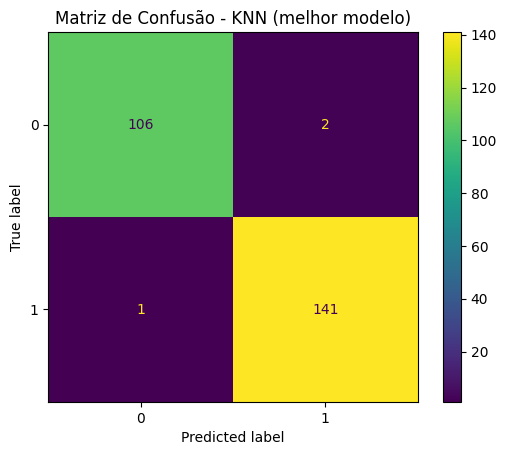

[OK] Arquivos: /content/predicoes_knn.csv | /content/test_set_com_preds.csv

[Custo computacional — SUPERVISIONADO]
 - train_total_sec: 9.1249 s
 - split_plus_setup_sec: 0.0044 s


In [6]:
# Helpers
def guess_target(df):
    commons = ['target','label','classe','class','anomaly','y']
    for c in commons:
        if c in df.columns:
            return c
    n = len(df)
    cands = []
    for c in df.columns:
        if df[c].isna().mean() < 0.4:
            nun = df[c].nunique(dropna=True)
            if 2 <= nun <= min(20, max(2, n//3)):
                cands.append((c, nun))
    if cands:
        cands.sort(key=lambda t: t[1])
        return cands[0][0]
    return None

def _safe_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn >=1.2
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)         # sklearn <1.2

def make_pre(num_cols, cat_cols):
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', _safe_ohe())]) if len(cat_cols)>0 else 'drop'
    return ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')

# Selecionar modo
_mode = (MODE or 'auto').lower().strip()
if _mode not in {'auto','supervised','unsupervised'}:
    print(f"[WARN] MODE='{MODE}' inválido. Usando 'auto'."); _mode='auto'

picked_target = None
if _mode == 'supervised':
    if TARGET_NAME is None:
        picked_target = guess_target(df)
        if picked_target is None:
            raise ValueError("MODE='supervised' mas não achei coluna-alvo. Defina TARGET_NAME.")
    else:
        picked_target = TARGET_NAME
        if picked_target not in df.columns:
            raise ValueError(f"TARGET_NAME='{TARGET_NAME}' não existe no dataset.")
elif _mode == 'unsupervised':
    picked_target = None
else:  # auto
    if TARGET_NAME and TARGET_NAME in df.columns:
        picked_target = TARGET_NAME
        print(f"[AUTO] Usando TARGET_NAME fornecido: {picked_target}")
        _mode = 'supervised'
    else:
        g = guess_target(df)
        if g and g in df.columns:
            picked_target = g
            print(f"[AUTO] Alvo inferido: '{picked_target}'. Usando SUPERVISIONADO (KNN).")
            _mode = 'supervised'
        else:
            picked_target = None
            print("[AUTO] Nenhum alvo detectado. Usando NÃO SUPERVISIONADO (K-Means).")
            _mode = 'unsupervised'

id_cols = [c for c in ID_COLS_GUESS if c in df.columns]

cost = {}

# --- SUPERVISIONADO: KNN ---
if _mode == 'supervised':
    print("\n===== MODO SUPERVISIONADO (KNN) =====")
    y = df[picked_target].copy()
    X = df.drop(columns=[picked_target]+id_cols, errors='ignore').copy()
    if X.shape[1] == 0:
        raise ValueError("Não há colunas de atributos após remover alvo/IDs.")

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    pre = make_pre(num_cols, cat_cols)

    stratify_opt = y if y.nunique() > 1 else None
    t0 = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=stratify_opt)
    pipe = Pipeline([('pre', pre), ('knn', KNeighborsClassifier())])
    param_grid = {'knn__n_neighbors':[3,5,7,9,11], 'knn__weights':['uniform','distance'], 'knn__p':[1,2]}

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1, verbose=0)
    t_fit0 = time.time()
    grid.fit(X_train, y_train)
    t_fit1 = time.time()

    cost['train_total_sec'] = t_fit1 - t_fit0
    cost['split_plus_setup_sec'] = t_fit0 - t0

    print("[Best] Params:", grid.best_params_)
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    print(f"[Eval] Accuracy: {acc:.4f} | F1-macro: {f1m:.4f}\n")
    print(classification_report(y_test, y_pred, digits=4))

    try:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.title("Matriz de Confusão - KNN (melhor modelo)")
        plt.show()
    except Exception as e:
        print("[WARN] Não foi possível plotar a matriz de confusão:", e)

    # Saídas
    pred_df = pd.DataFrame({'y_true': y_test.values, 'y_pred': y_pred}, index=y_test.index)
    for c in id_cols:
        if c in df.columns:
            pred_df[c] = df.loc[pred_df.index, c].values

    pred_df.to_csv('/content/predicoes_knn.csv', index=False, encoding='utf-8')
    X_test.assign(y_true=y_test, y_pred=y_pred).to_csv('/content/test_set_com_preds.csv', index=False, encoding='utf-8')
    print("[OK] Arquivos: /content/predicoes_knn.csv | /content/test_set_com_preds.csv")

    print("\n[Custo computacional — SUPERVISIONADO]")
    for k, v in cost.items():
        print(f" - {k}: {v:.4f} s")

# --- NÃO SUPERVISIONADO: K-Means ---
else:
    print("\n===== MODO NÃO SUPERVISIONADO (K-Means) =====")
    X = df.drop(columns=id_cols, errors='ignore').copy()

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    pre = make_pre(num_cols, cat_cols)

    t_pre0 = time.time()
    X_proc = pre.fit_transform(X)
    t_pre1 = time.time()

    n_samples = X_proc.shape[0]
    if n_samples < 3:
        raise ValueError("Dados insuficientes para clustering (mínimo 3 amostras).")

    rng = np.random.RandomState(RANDOM_STATE)
    eval_idx = np.arange(n_samples) if n_samples <= 5000 else rng.choice(n_samples, size=5000, replace=False)

    k_min, k_max = 2, min(8, max(2, n_samples - 1))
    best_k, best_sil = None, -1.0
    t_sel0 = time.time()
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
        labels_k = km.fit_predict(X_proc)
        if len(np.unique(labels_k)) > 1:
            s = silhouette_score(X_proc[eval_idx], labels_k[eval_idx])
            if s > best_sil:
                best_sil, best_k = s, k
    t_sel1 = time.time()

    if best_k is None:
        best_k = 2
        print("[WARN] Silhouette não definido; usando K=2.")
    else:
        print(f"[INFO] K ótimo (silhouette): {best_k}  | silhouette={best_sil:.4f}")

    t_fit0 = time.time()
    final_kmeans = Pipeline([('pre', pre), ('km', KMeans(n_clusters=best_k, n_init='auto', random_state=RANDOM_STATE))])
    labels = final_kmeans.fit_predict(X)
    t_fit1 = time.time()

    # Distância ao centróide
    X_for_dist = pre.transform(X)
    km_step = final_kmeans.named_steps['km']
    _, dist = pairwise_distances_argmin_min(X_for_dist, km_step.cluster_centers_)

    out_df = df.copy()
    out_df['cluster'] = labels
    out_df['dist_to_centroid'] = dist

    print("\n[Contagem por cluster]")
    print(out_df['cluster'].value_counts().sort_index())

    # PCA 2D
    try:
        comp = 2 if X_for_dist.shape[1] >= 2 else 1
        pca = PCA(n_components=comp, random_state=RANDOM_STATE)
        Xp = pca.fit_transform(X_for_dist)
        plt.figure(figsize=(6,5))
        plt.scatter(Xp[:,0], Xp[:,1] if comp==2 else np.zeros_like(Xp[:,0]), s=10, c=labels)
        plt.title(f"K-Means (k={best_k}) - PCA 2D")
        plt.xlabel("PC1"); plt.ylabel("PC2" if comp==2 else "(constante)")
        plt.show()
    except Exception as e:
        print("[WARN] Não foi possível plotar PCA:", e)

    out_df.to_csv('/content/clustered.csv', index=False, encoding='utf-8')
    print("[OK] Arquivo: /content/clustered.csv")

    # ---- Relatório por cluster (numéricas + top categorias) ----
    print("\n[Resumo por cluster — Numéricas: média/mediana]")
    if num_cols:
        print("Médias:")
        print(out_df.groupby('cluster')[num_cols].mean().round(4))
        print("\nMedianas:")
        print(out_df.groupby('cluster')[num_cols].median().round(4))
    else:
        print("Não há colunas numéricas.")

    if cat_cols:
        print("\n[Top categorias por cluster (até 10 colunas)]")
        for c in cat_cols[:10]:
            print(f"\n - Coluna: {c}")
            top = out_df.groupby('cluster')[c].agg(lambda s: s.value_counts().head(3))
            print(top)
    else:
        print("\nNão há colunas categóricas.")

    # ---- Custo computacional ----
    print("\n[Custo computacional — NÃO SUPERVISIONADO]")
    print(f" - preprocess_fit_transform_sec: {(t_pre1 - t_pre0):.4f} s")
    print(f" - k_selection_loop_sec: {(t_sel1 - t_sel0):.4f} s")
    print(f" - final_model_fit_sec: {(t_fit1 - t_fit0):.4f} s")

## 6) Baixar os arquivos de saída
Clique para baixar os resultados para sua máquina e anexar no relatório da equipe.

In [ ]:
try:
    from google.colab import files
    for p in ['/content/clustered.csv', '/content/predicoes_knn.csv', '/content/test_set_com_preds.csv']:
        if Path(p).exists():
            files.download(p)
except Exception as e:
    print("Se estiver fora do Colab, abra a lateral 'Arquivos' e baixe manualmente.")